# States, gates and measurements

Every computation consists of three parts:
* state preparation - in Qiskit it is always state $|0\rangle$,
* state evolution - changes to states, in quantum computers composed of simple gates,
* measurements - in Qiskit only in $\{|0\rangle, |1\rangle\}$ basis.

Due to the limitations imposed by the state preparation and measurement in Qiskit, if we want to prepare a specific state, or if we want to measure in different basis, we need to bypass the limitations by specific changes we perform to state $|0\rangle$ and to the computed state before $\{|0\rangle, |1\rangle\}$ measurement. We will go through these steps on the simplest quantum system, on the *qubit*. Along the way we will learn basic functionality of Qiskit library.

Practical quantum computations have their specifics, as we are finding out, but the structure of computation is similar to the classical computation, where we apply different gates on register to obtain some desired outcome. In quantum cases the register will be composed of qubits, the gates will perform unitary changes (represented by unitary matrices) and the readout is obtained through measurement from the qubit register to the classical register. As we will see, the circuits will be drawn also similarly to the classical case.

## Qubit

Qubits are vectors in $\mathbb C^2$ and so they are defined by two complex numbers. One degree of freedom is removed because we do not care about complex unit prefactor of the vector and another is removed because we want our states to be normalized, $\langle\psi|\psi\rangle=1$. We will now look at different ways of looking at states in *Qiskit*.

In [2]:
# Basic initiallizations
import qiskit
import random
import math
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec,\
    plot_bloch_multivector, plot_state_hinton, plot_state_qsphere
from qiskit_aer import AerSimulator, StatevectorSimulator

Let us start with a simple circuit having one qubit and no classical register.

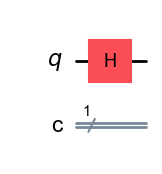

In [3]:
circ = qiskit.QuantumCircuit(1, 1) # initializes circuit with 1 qubit and 1 classical bit (for readout)
circ.h(0) # applies hadamard transform H on the qubit 0
circ.draw(output="mpl") # draws out the circuit

We can define measurement separately.

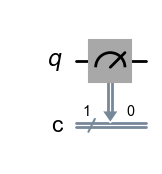

In [4]:
measure_z = qiskit.QuantumCircuit(1, 1) # measurement will be defined on circuit with
                                        # one qubit and one (readout) classical bit
measure_z.measure(0, 0) # applies measurement from qubit 0 to bit 0
                        # without parameters performs measurement of the whole register to a bit register
measure_z.draw(output="mpl")

The basic circuit can now be composed with the measurement into larger circuit to make *the quantum random number generator*.

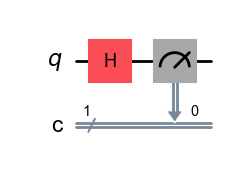

In [5]:
circZ = circ.compose(measure_z)
circZ.draw(output="mpl")

We have seen this circuit previously and we know what we will measure.

In [6]:
sim = AerSimulator()
job = sim.run(circZ, shots=10000, memory=True) # executes 10000 runs of circZ on qasm backend (qasm_simulator)
print(job.result().get_counts()) # provides obtained results

{'0': 5092, '1': 4908}


These results can be presented in the form of histogram.

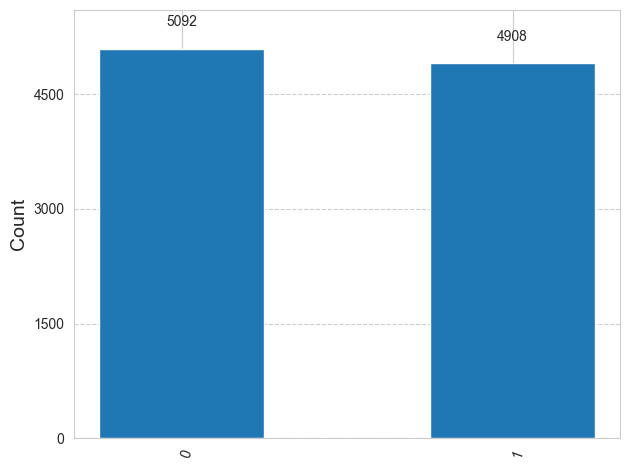

In [7]:
plot_histogram(job.result().get_counts()) # plots histogram of obtained results

Previous simulation performed 10000 experimental runs on given circuit, which is something that a real experiment (and real quantum computer) would give us. But this information is not complete - single measurement gives us only partial information and only in a statistical form. What we find are the probabilities of obtaining given outcomes. In previous case in <code>circ</code> we prepared the $|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ state. But the measurements measures in $\{|0\rangle,|1\rangle\}$ basis. The probabilities are given by the *Born rule:* having a state $|\psi\rangle$, the probability of measuring it in (basis) state $|\phi\rangle$ is $p_{\phi}(|\psi\rangle)=|\langle\phi | \psi\rangle|^2$. In this case we find $p_0(|+\rangle)=p_1(|+\rangle)=1/2$. So roughly half of the results (5000) should give outcome 0 and half should give outcome 1. This circuit presents the **quantum random number generator** (although only when run on quantum device). In such case, the particular outcomes are random numbers:

In [8]:
shots = job.result().get_memory()
print(f"First few particular outcomes are: {shots[:20]}")

First few particular outcomes are: ['0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '1', '1', '0', '1', '0']


Previous description via simulation does offer a good way of comparing with experiments, but we can gat full information about the state (before measurement) by invoking the <code>statevector_simulator</code> backend. Note, that now we will use circuit without measurement, because we want to see what the state is before the measurement; if we would look at it after measurement, the state would be changed into one of the measurement basis states randomly.

In [9]:
vecsim = StatevectorSimulator() # statevector simulator backend
job = vecsim.run(circ) 
result = job.result()
psi = result.get_statevector()

The output state (before measurement) is now stored in <code>psi</code>

In [10]:
print(psi)

Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


We can visualise it in several different ways. For now we will use Bloch vector representation - each state can be represented as a vector on a sphere (vis. two free parameters described at the beginning).

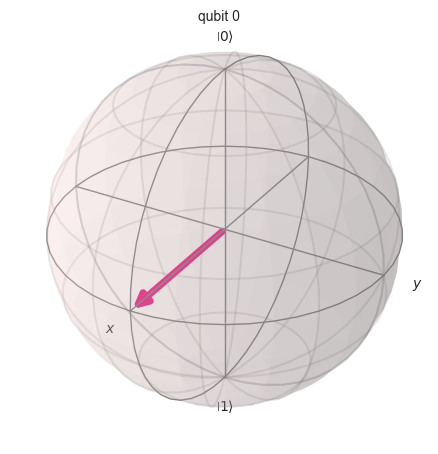

In [11]:
plot_bloch_multivector(psi)

Other forms include functions <code>plot_state_paulivec(psi)</code>, <code>plot_state_hinton(psi)</code>, <code>plot_state_city(psi)</code>, <code>plot_state_qsphere(psi)</code> and others. They all represent the same information about the state, but represented differently. Without going into explanation, you can run them next.

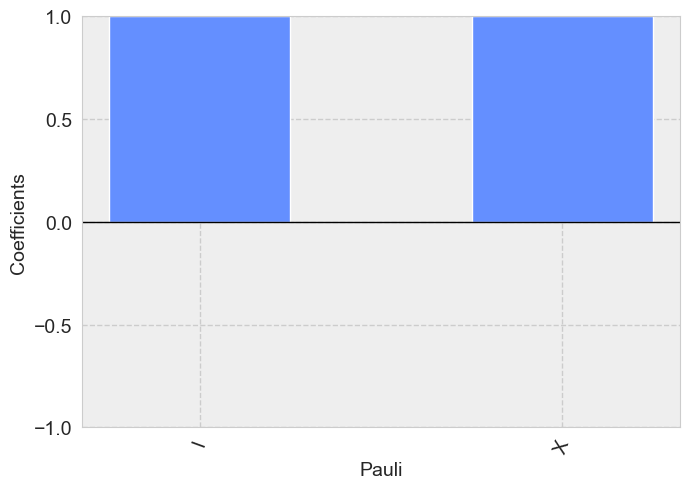

In [12]:
plot_state_paulivec(psi)

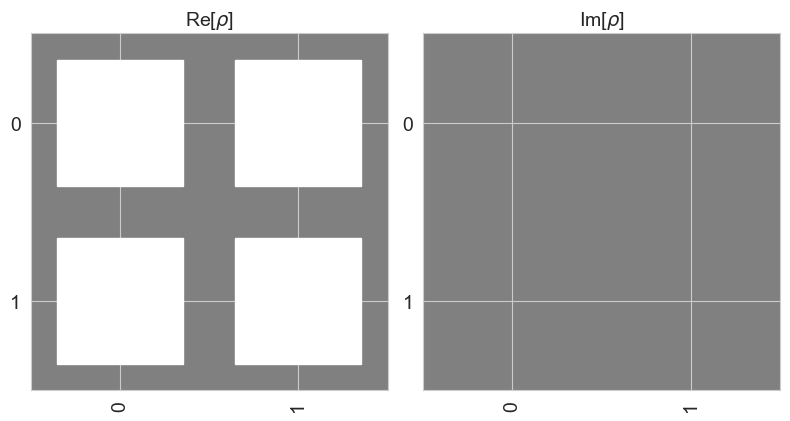

In [13]:
plot_state_hinton(psi)

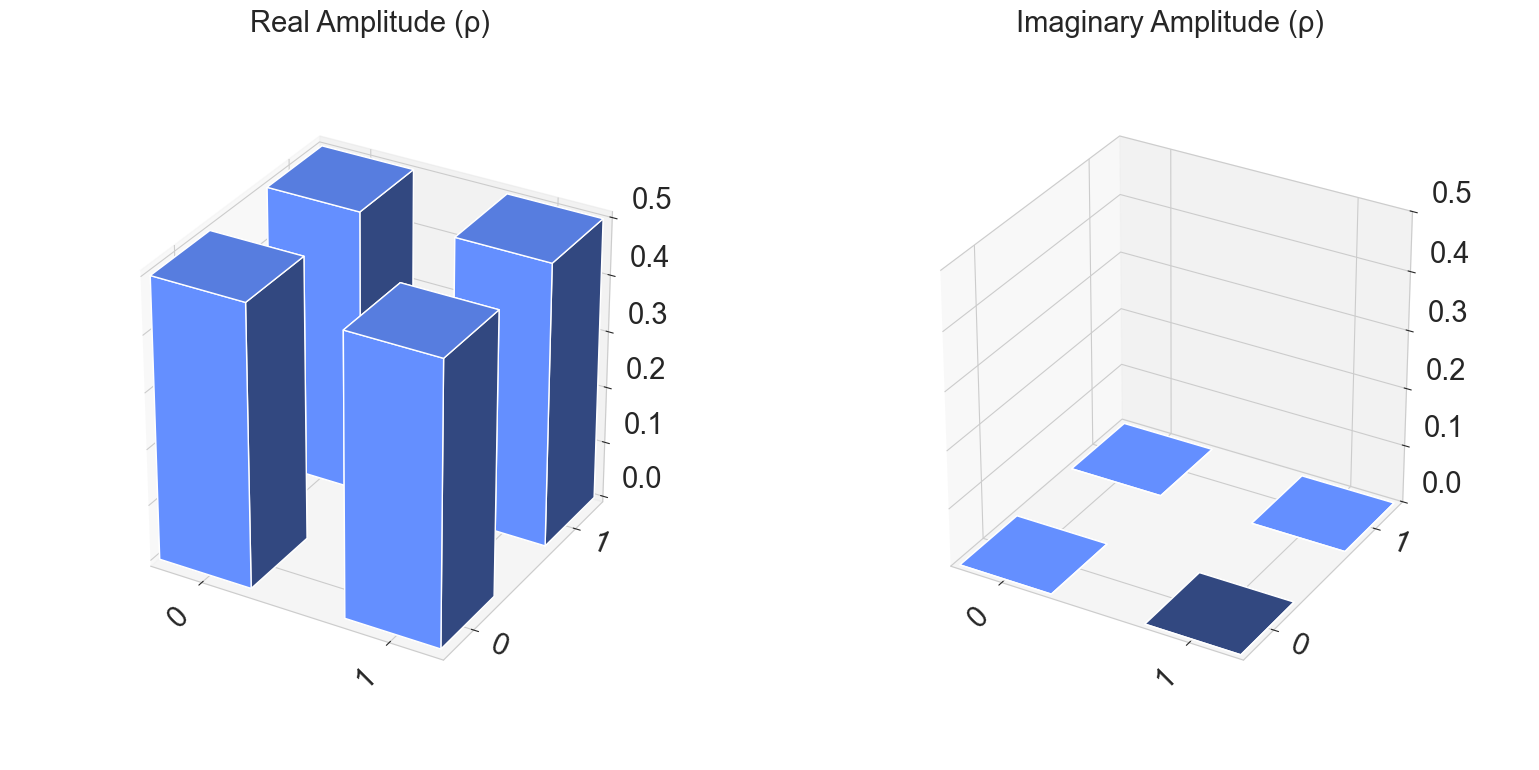

In [14]:
plot_state_city(psi)

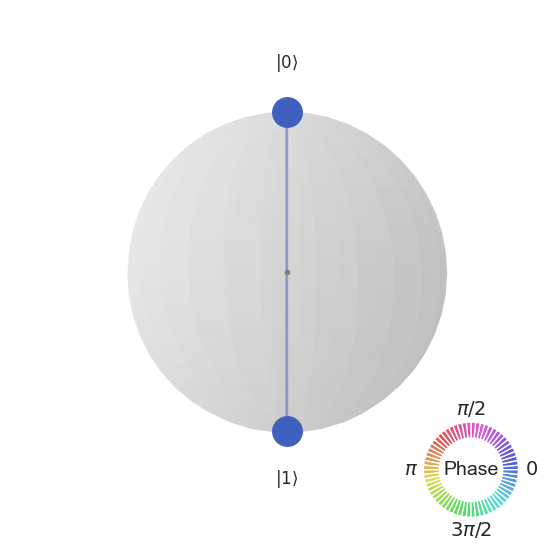

In [15]:
plot_state_qsphere(psi)

## Preparing (random state)

In the previous part we started with state $|0\rangle$ and applied Hadamard gate on it. Hadamard gate in the theoretical desription applies unitary matrix

$$
H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1\end{pmatrix}
$$

on the state on the input. We can look at $H$ as a part of computation, but we can look at it also as a state $|+\rangle$ preparation.

To change some state, or to prepare a state we have multiple options of gates to apply. An exhaustive list can be found online, but we will use only a fraction of those gates. We will mostly use Hadamard gate (`h`), NOT gate, or Pauli $\sigma_x$ gate (`x`), or the universal single-qubit rotation gate

$$
U_3(\theta, \phi, \lambda) = \begin{pmatrix}
\cos(\theta/2) & -e^{i\lambda}\sin(\theta/2) \\
e^{i\phi}\sin(\theta/2) & e^{i\lambda + i\phi}\cos(\theta/2)
\end{pmatrix}.
$$

We will now look at how to prepare some specific state. We choose at the beginning some random rotation of the state $|0\rangle$, then predict the outcome probabilities for measurement in the computational basis, run the simulator and compare the results with our theoretical predictions. To rotate state we will use the $U_3(\theta, \phi, \lambda)$ unitary gate. In Qiskit $U_3$ is implemented by method `u`.

In [16]:
theta = math.pi * random.random() # theta can be restricted to interval [0, pi]
phi = 2 * math.pi * random.random() # phi will be from interval [0, 2pi]
lam = 2 * math.pi * random.random() # lambda will be from interval [0, 2pi]
print("Chosen angles are:", (theta, phi, lam))

Chosen angles are: (2.962024654215577, 6.022524543343896, 2.085864106007391)


Let us prepare a circuit that rotates the state $|0\rangle$ around $y$ axis. Rotation by $\pi/2$ performs a Hadamard transform.

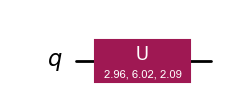

In [17]:
rot = qiskit.QuantumCircuit(1)
rot.u(theta, phi, lam, 0)
job = vecsim.run(rot)
psi = job.result().get_statevector(rot)
rot.draw(output="mpl")

We can find what the prepared state $|\psi\rangle$ now is:

In [18]:
print(psi)

Statevector([0.08966342+0.j        , 0.96232808-0.25668099j],
            dims=(2,))


We can gain draw the Bloch sphere representation

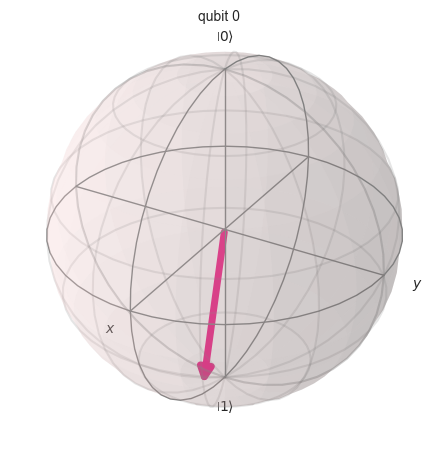

In [19]:
plot_bloch_multivector(psi)

The probabilities to obtain 0 or 1 is then given by $p_0=|\langle 0|\psi\rangle|^2$ and $p_1=|\langle 1|\psi\rangle|^2$; these probabilities can be obtained directly from the statevector (which is exact):

In [20]:
print("p0 =",abs(psi[0])**2)
print("p1 =",abs(psi[1])**2)

p0 = 0.008039529065608841
p1 = 0.9919604709343911


But we can get these probabilities also directly from the initial angle. The state after transform $U_3(\theta, \phi, \lambda)$ is
$$
U_3(\theta,\phi,\lambda)|0\rangle = \begin{pmatrix}
\cos(\theta/2) & -e^{i\lambda}\sin(\theta/2) \\
e^{i\phi}\sin(\theta/2) & e^{i\lambda + i\phi}\cos(\theta/2)
\end{pmatrix}\begin{pmatrix} 1 \\ 0\end{pmatrix} = \begin{pmatrix} \cos\frac{\theta}{2} \\ e^{i\phi}\sin\frac{\theta}{2} \end{pmatrix} $$
and so $p_0=\cos^2\frac{\theta}{2}$ and $p_1=\sin^2\frac{\theta}{2}$:

In [21]:
p_th = {"0": math.cos(theta / 2)**2, "1": math.sin(theta / 2)**2}
print("p0 =", p_th["0"])
print("p1 =", p_th["1"])

p0 = 0.008039529065608841
p1 = 0.9919604709343911


Finally, if we run the program several times on simulator, the probabilities we obtain are similar.

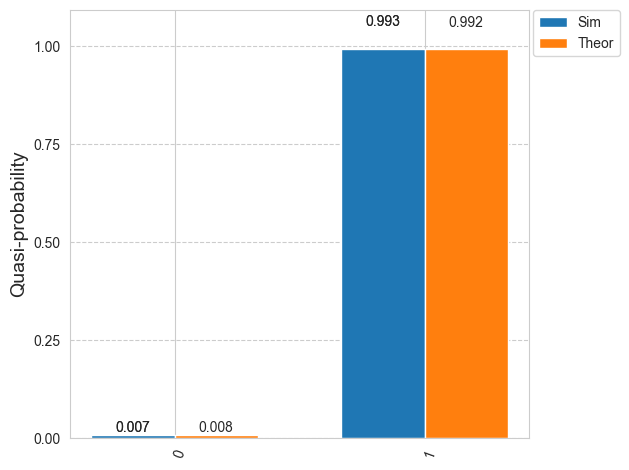

In [22]:
job = sim.run(rot.compose(measure_z), shots=10000)
plot_histogram([job.result().get_counts(), p_th], legend=["Sim", "Theor"])

## Measuring in basis

It was shown that measurement in basis $\{U|0\rangle, U|1\rangle\}$ of a state $|\psi\rangle$ is the same as measurement of state $U^\dagger|\psi\rangle$ in basis $\{|0\rangle, |1\rangle\}$. For example if we want to measure in basis $\{|\pm\rangle\}$, which is obtained from the computational basis by Hadamard gate $H$, it is the same as first transforming state by the gate $H^\dagger$ and then measuring in the computational basis. And since $H^\dagger=H$, measurement in Hadamard basis is simply done by transforming state by the Hadamard gate and then measuring in the computational basis:

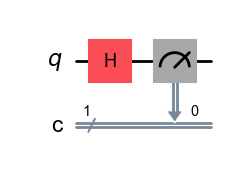

In [23]:
measure_h = qiskit.QuantumCircuit(1, 1) # measurement will be defined on circuit with
                                        # one qubit and one (readout) classical bit
measure_h.h(0) # change of basis
measure_h.measure(0, 0) # applies measurement from qubit 0 to bit 0
                        # without parameters performs measurement of the whole register to a bit register
measure_h.draw(output="mpl")

**Task:** Now write a program that
1. Prepares state $|-\rangle$,
2. Measures it in randomly chosen basis
3. Compares simulated results with your theoretical predictions

The structure of your program should follow structure:

In [22]:
## 0. Import necessary libraries (if you need some new ones)
## 1. Initialize circuit
## 2. Prepare state |->
## 3. Choose (theta, phi, lam) of u that define the rotation of the basis {|0>, |1>}
##    to basis {U|0>, U|1>}
## 4. Find such parameters (theta2, phi2, lam2) for which the rotation of
##    the state will perform measurement in the basis from point 3, i.e. find
##    parameters for adjoint motrix of U
## 5. Perform measurement and obtain simulated results
## 6. Compute theoretical probabilities for the outcomes and compare these probabilities with
##    the simulated results